In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%load_ext lab_black

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE, figsize=(8, 8))  # fontsize of the figure title

In [2]:
from src.model.preprocess import Preprocessor

In [3]:
columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "salary_class",
]

In [4]:
df_raw = pd.read_csv("../data/raw/adult.data", header=None, names=columns)
df_test_raw = pd.read_csv("../data/raw/adult.test", header=None, names=columns).dropna()

In [5]:
preproc = Preprocessor()

In [6]:
df = preproc.clean(df_raw)
X_df = preproc.X_df
y = preproc.y_ser.values

df_test = preproc.clean(df_test_raw)
X_df_test = preproc.X_df
y_test = preproc.y_ser.values

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    roc_curve,
    plot_roc_curve,
    make_scorer,
    f1_score,
    roc_auc_score,
)

In [27]:
auc_scorer = make_scorer(roc_auc_score)

In [28]:
column_trans = ColumnTransformer(
    [
        (
            "enc",
            OneHotEncoder(dtype="int", drop="first", sparse=False),
            ["workclass", "marital_status", "occupation", "relationship", "sex"],
        ),
    ],
    remainder="passthrough",
)

In [29]:
log_params = dict(red_dim__n_components=[2, 5, 10], clf__C=[0.1, 10, 100],)
log_pipe = Pipeline(
    [
        ("col_preproc", column_trans),
        ("red_dim", PCA(n_components=5)),
        ("clf", LogisticRegression(class_weight="balanced")),
    ]
)
log_grid = GridSearchCV(log_pipe, log_params, scoring=auc_scorer)

In [30]:
cat_params = dict(depth=[4, 6, 8, 10])
cat = CatBoostClassifier(
    auto_class_weights="Balanced",
    cat_features=["workclass", "marital_status", "occupation", "relationship", "sex"],
)
cat_grid = GridSearchCV(cat, cat_params, scoring=auc_scorer)

In [31]:
xgb_params = dict(clf__reg_lambda=[0, 1, 10, 100])
xgb_pipe = Pipeline(
    [("col_preproc", column_trans), ("clf", XGBClassifier(scale_pos_weight=3.15)),]
)

xgb_grid = GridSearchCV(xgb_pipe, xgb_params)

xgbrf_params = dict(clf__reg_lambda=[0, 1, 10, 100])
xgbrf_pipe = Pipeline(
    [("col_preproc", column_trans), ("clf", XGBRFClassifier(scale_pos_weight=3.15)),]
)

xgbrf_grid = GridSearchCV(xgbrf_pipe, xgbrf_params, scoring=auc_scorer)

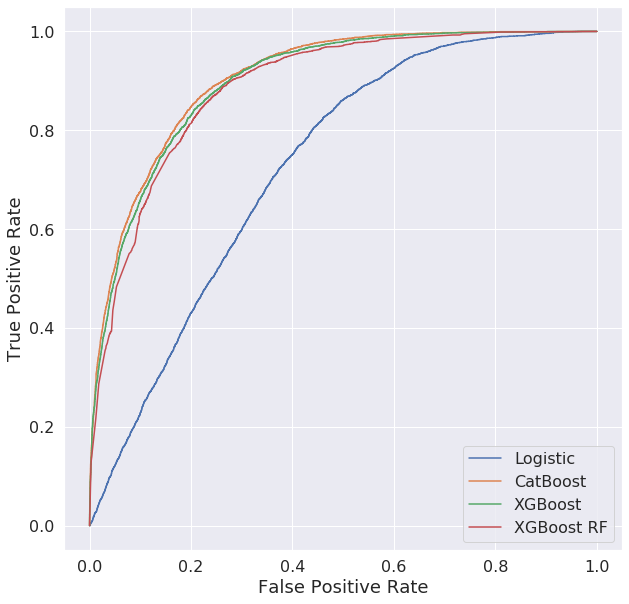

In [32]:
log_grid.fit(X_df, y)
cat_grid.fit(X_df, y, silent=True)
xgb_grid.fit(X_df, y)
xgbrf_grid.fit(X_df, y)

fig, ax = plt.subplots(figsize=(10, 10))
plot_roc_curve(log_grid, X_df_test, y_test, label="Logistic", ax=ax)
plot_roc_curve(cat_grid, X_df_test, y_test, label="CatBoost", ax=ax)
plot_roc_curve(xgb_grid, X_df_test, y_test, label="XGBoost", ax=ax)
plot_roc_curve(xgbrf_grid, X_df_test, y_test, label="XGBoost RF", ax=ax)